In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [4]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [343]:
def process_one_location(df, location, impute = False, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
    
    if take_log:
        subset_augmented['PM2.5'] = subset_augmented['PM2.5'].map(lambda x: np.log(x))
    
    if take_diff:
        subset_notna_index = (subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)).notna() #record which index is NaN before imputation
    else:
        subset_notna_index = subset_augmented["PM2.5"].notna() #record which index is NaN before imputation
    
    truey_notna_index = subset_augmented["PM2.5"].notna() #record which index is NaN before imputation
    
    if impute:
        subset_augmented = subset_augmented.interpolate(method = 'ffill')#fill foward, to aviod leakage
    
    subset_augmented = feature_engineering(subset_augmented,n_lag,take_diff)

    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    true_y.loc[~truey_notna_index,'PM2.5'] = np.nan #set the imputed target back to NaN
    
    if take_diff:
        subset_augmented['target'] = subset_augmented['PM2.5_diff']
        subset_augmented.loc[~subset_notna_index,'target'] = np.nan #set the imputed target back to NaN
        subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    else:
        subset_augmented['target'] = subset_augmented['PM2.5']
        subset_augmented.loc[~subset_notna_index,'target'] = np.nan #set the imputed target back to NaN
        subset_augmented = subset_augmented.drop(columns=['PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag, take_diff=True):
    if take_diff:
        subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
        subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
        subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
#         subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
        subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
#         subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
        subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
#         subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
        subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
#         subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented,take_diff)
    
    subset_augmented = calculate_rolling_stat(subset_augmented,take_diff)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
    
    #additional lags for PM2.5  
    for lag in range(n_lag+1,24): #has great predictive power
        tmp = pd.DataFrame(subset_augmented[col[0]].shift(lag))
        tmp.columns = [f'{col[0]}_lag_{lag}']
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for p in col:
        res[f'{p}_daily_mean'] = res[p].rolling(24,min_periods=1).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24,min_periods=1).median()
        res[f'{p}_daily_std'] = res[p].rolling(24,min_periods=1).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7,min_periods=1).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7,min_periods=1).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7,min_periods=1).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30,min_periods=1).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30,min_periods=1).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30,min_periods=1).std()
    return res

In [344]:
IS_TAKING_LOG=False
IS_TAKING_DIFF=True
IS_IMPUTE = True

In [345]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,impute = IS_IMPUTE, take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF,n_lag=3)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [346]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,impute = IS_IMPUTE,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF,n_lag=3)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

In [347]:
corr_data = allTarget[["PM2.5","location"]].pivot(columns='location')
corr = allTarget[["PM2.5","location"]].pivot(columns='location').corr()
# plt.figure(figsize=(20,15))
# sns.set(font="SimSun")
# sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
#             annot_kws={"size": 7}, vmin=0.4, vmax=1)

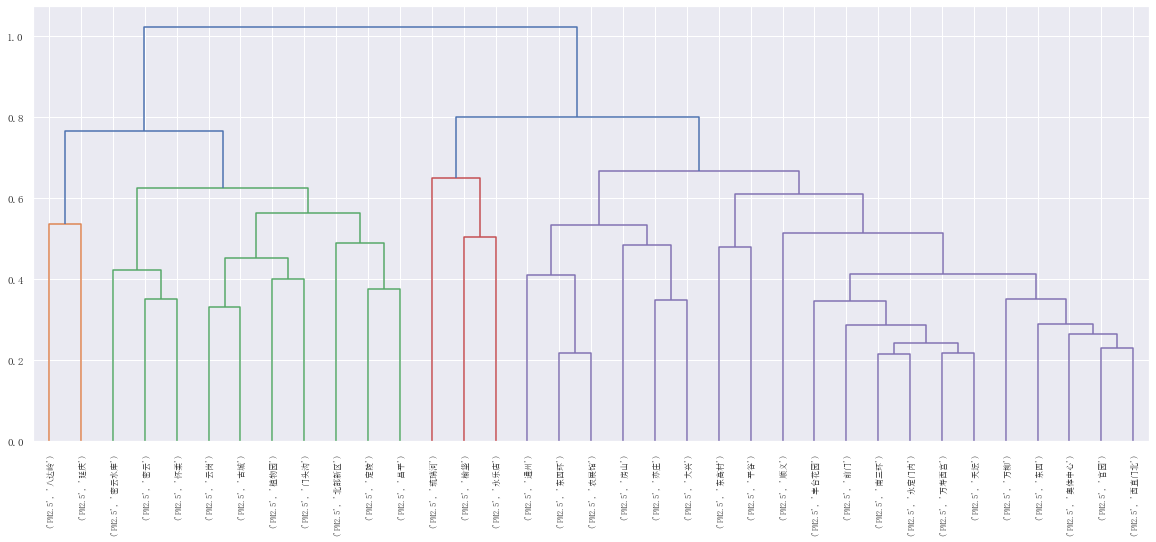

In [348]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize=(20,8))
sns.set(font="SimSun",font_scale=1)
dissimilarity = np.sqrt(2*(1 - corr))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=corr_data.columns, orientation='top', 
           leaf_rotation=90);

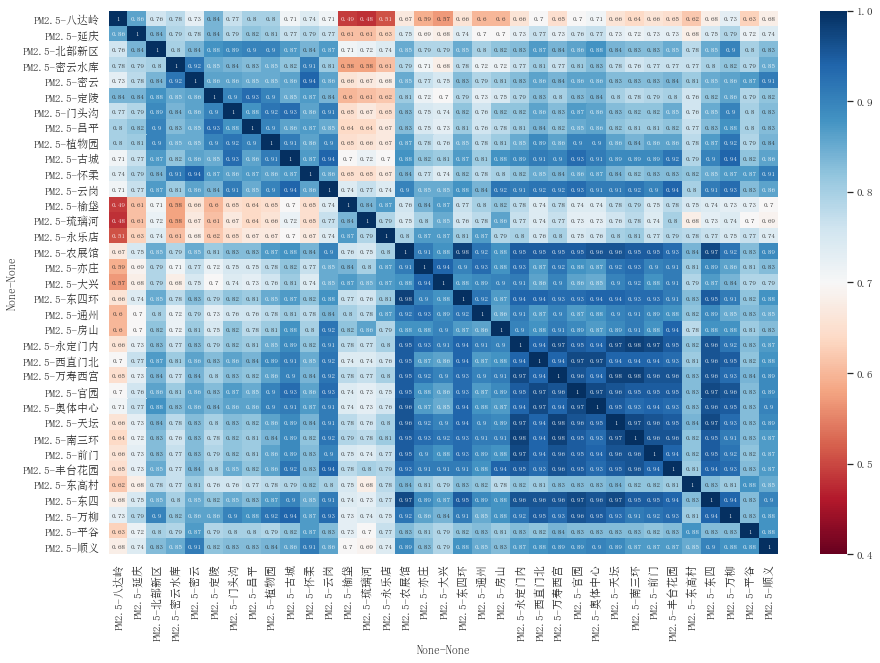

In [349]:
labels = fcluster(Z, t=5, criterion='maxclust')

labels_order = np.argsort(labels)

for idx, i in enumerate(corr_data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(corr_data[i])
    else:
        df_to_append = pd.DataFrame(corr_data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,10))
sns.set(font="SimSun",font_scale=1)
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1);

In [350]:
label_map = {c[1]:labels[i] for i,c in enumerate(corr_data.columns)}
def get_cluster_stats(labels,data):
    data = data.copy(deep=True)
    data['cluster'] = data['location'].map(lambda x: labels[x])
#     c.groupby('b').agg({'a': lambda x: x.mean(skipna=False)})
    tmp = data.groupby([data.index,'cluster'],as_index=False).mean()
    tmp = tmp.set_index(data.groupby([data.index,'cluster']).mean().index.get_level_values(0))
    newdf = pd.DataFrame()
    for c in set(tmp.cluster):
        cluster = tmp[tmp['cluster']==c]
        cluster.columns = [f'{col}_c{c}' for col in tmp.columns]
        newdf = pd.concat([newdf, cluster],axis=1)
    newdf = newdf[[col for col in newdf.columns if 'PM2.5' in col]]
    newdf = pd.merge(newdf,data,left_index=True,right_index=True)
    newdf.drop(columns=['cluster'],inplace=True)
    del tmp
    gc.collect()
    return newdf

In [351]:
alldata = get_cluster_stats(label_map,alldata)
allTestdata = get_cluster_stats(label_map,allTestdata)

In [352]:
# if IS_TAKING_DIFF:
#     alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
# else:
#     alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

# if IS_TAKING_DIFF:
#     allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
# else:
#     allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

In [353]:
def filter_na(data,true_y,locations):
    res = pd.DataFrame()
    res_test = pd.DataFrame()
    for l in locations:
        subset = data[data['location']==l]
        testing_y = true_y[true_y['location']==l]
        train_notna_index = subset['target'].notna()
        subset = subset[train_notna_index]
        testing_y = testing_y[train_notna_index]
        
        res = pd.concat([res,subset])
        res_test = pd.concat([res_test,testing_y])
    return res, res_test

In [354]:
alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [355]:
allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [356]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [357]:
def add_freq_features(df): 
    timestamp_seconds = df.index.map(pd.Timestamp.timestamp)

    hours = 60*60
    days = 24*hours
    weeks = 24*7*hours
    months = 24*30*hours
    years = 24*30*12*hours

    df['days_sin'] = np.sin(timestamp_seconds * (2 * np.pi / days))
    df['days_cos'] = np.cos(timestamp_seconds * (2 * np.pi / days))
    df['weeks_sin'] = np.sin(timestamp_seconds * (2 * np.pi / weeks))
    df['weeks_cos'] = np.cos(timestamp_seconds * (2 * np.pi / weeks))
    df['months_sin'] = np.sin(timestamp_seconds * (2 * np.pi / months))
    df['months_cos'] = np.cos(timestamp_seconds * (2 * np.pi / months))
    df['years_sin'] = np.sin(timestamp_seconds * (2 * np.pi / years))
    df['years_cos'] = np.cos(timestamp_seconds * (2 * np.pi / years))

    cols_at_end = ['location', 'target']
    df = df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]
    return df

alldata_noNA = add_freq_features(alldata_noNA)
allTestdata_noNA = add_freq_features(allTestdata_noNA)

In [358]:
# [c for c in alldata.columns if 'PM' in c ]

In [359]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [360]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [361]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [362]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.1842	valid_1's rmse: 12.7042
[1000]	training's rmse: 9.18723	valid_1's rmse: 11.7136
[1500]	training's rmse: 7.84227	valid_1's rmse: 10.9987
[2000]	training's rmse: 6.848	valid_1's rmse: 10.4494
[2500]	training's rmse: 6.07501	valid_1's rmse: 10.0404
[3000]	training's rmse: 5.45241	valid_1's rmse: 9.72342
[3500]	training's rmse: 4.93554	valid_1's rmse: 9.46509
[4000]	training's rmse: 4.50207	valid_1's rmse: 9.2564
[4500]	training's rmse: 4.13137	valid_1's rmse: 9.08944
[5000]	training's rmse: 3.81514	valid_1's rmse: 8.95106
[5500]	training's rmse: 3.54028	valid_1's rmse: 8.83389
[6000]	training's rmse: 3.2982	valid_1's rmse: 8.73567
[6500]	training's rmse: 3.08795	valid_1's rmse: 8.65311
[7000]	training's rmse: 2.90175	valid_1's rmse: 8.58481
[7500]	training's rmse: 2.73491	valid_1's rmse: 8.52465
[8000]	training's rmse: 2.58383	valid_1's rmse: 8.47275
[8500]	training's rmse: 2.44755	valid_1'

In [363]:
def process_prediction(predicted, true_y, take_log=True, take_diff=True):
    true_y['predicted'] = predicted
    if take_diff:
        true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    else:
        true_y['prediction'] = true_y['predicted']
        
    true_y['prediction'] = true_y['prediction'].map(lambda x: max(x,0)) # floor at 0
    true_y['prediction'] = true_y['prediction'].map(lambda x: min(x,1000)) # cap at 1000
    
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [364]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.138040849216537
Out of sample RMSE for LightGBM method is 12.781554818110596
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [365]:
print(f'In sample RMSE for LightGBM method is {r2_score(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for LightGBM method is {r2_score(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"])}')

print(f'In sample RMSE for Naive method is {r2_score(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for Naive method is {r2_score(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"])}')

In sample RMSE for LightGBM method is 0.9848043921148473
Out of sample RMSE for LightGBM method is 0.9805310500238287
In sample RMSE for Naive method is 0.9403621340239634
Out of sample RMSE for Naive method is 0.9417088005212829


Text(0.5, 1.0, '40 TOP feature importance over 5 folds average')

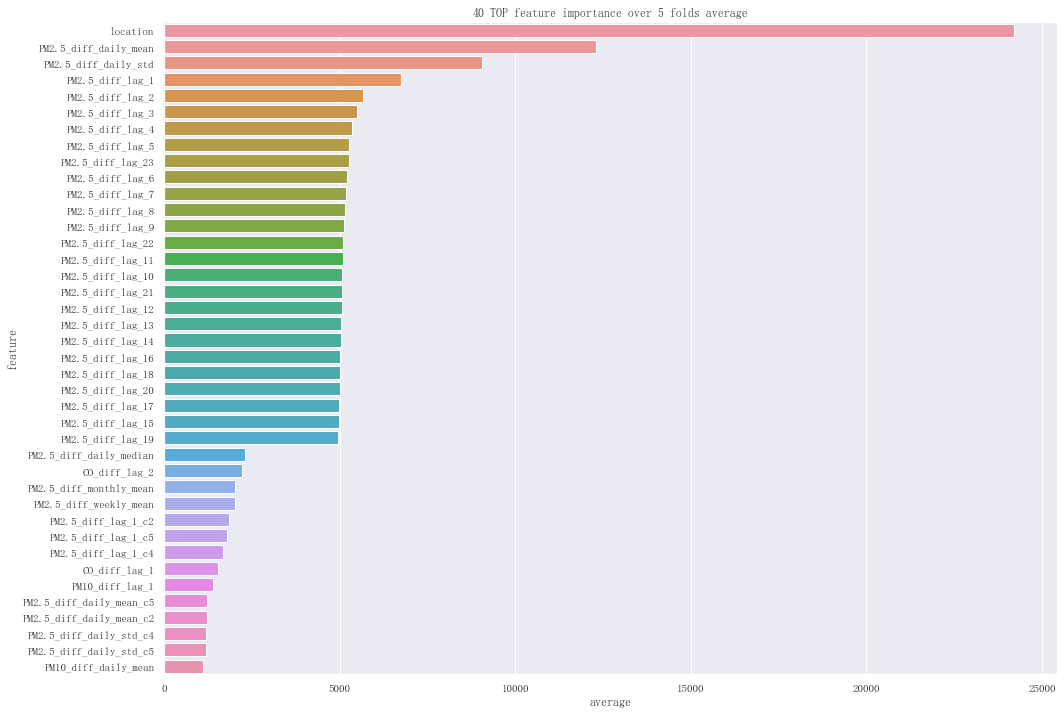

In [366]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(40), x='average', y='feature')
plt.title('40 TOP feature importance over {} folds average'.format(n_splits))

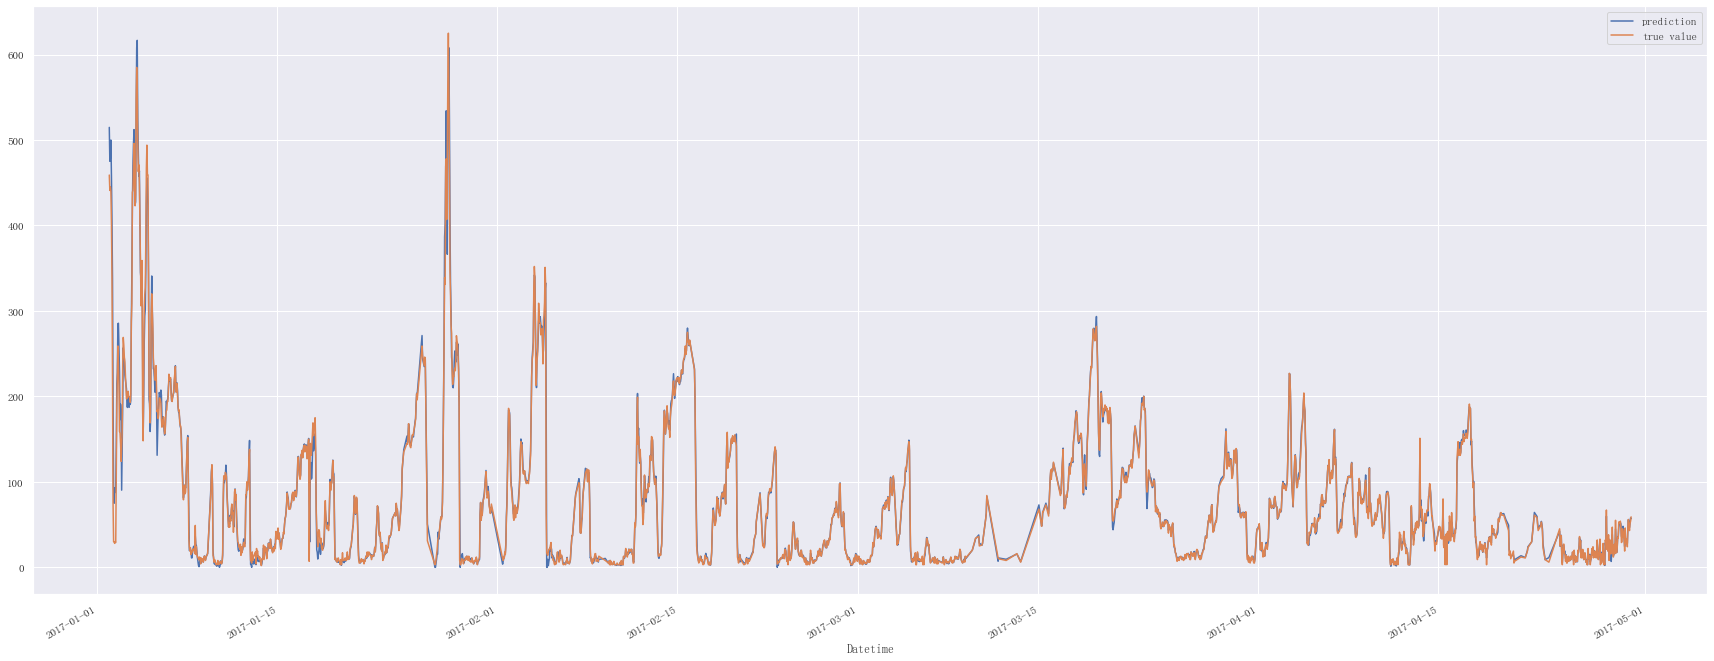

In [367]:
plt.figure(figsize=(30, 12))
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['prediction'].plot(label='prediction')
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['PM2.5'].plot(label='true value')
plt.legend()
plt.show()

In [369]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    15.959290
万柳      10.130091
东四      12.248460
东四环     10.164386
东高村     12.445149
丰台花园     9.753374
云岗      14.211937
亦庄       8.678342
八达岭      5.904044
农展馆     10.703474
前门      15.163455
北部新区    11.717023
南三环     16.574535
古城      13.415653
大兴      13.284990
天坛       9.122238
奥体中心    10.205217
官园      11.542880
定陵       7.490799
密云      11.394097
密云水库     8.063243
平谷      14.724490
延庆      10.497227
怀柔      11.280691
房山      15.912735
昌平      10.592174
植物园      9.844334
榆垡      20.143207
永乐店     12.824420
永定门内    16.331234
琉璃河     19.375594
西直门北    15.055632
通州      14.158644
门头沟     14.089958
顺义      10.740779
dtype: float64

In [41]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.216491528171813
Out of sample RMSE for LightGBM method is 15.053392432588659
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [42]:
print(f'In sample RMSE for LightGBM method is {r2_score(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for LightGBM method is {r2_score(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"])}')

print(f'In sample RMSE for Naive method is {r2_score(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for Naive method is {r2_score(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"])}')

In sample RMSE for LightGBM method is 0.9843384618719304
Out of sample RMSE for LightGBM method is 0.9707963933623361
In sample RMSE for Naive method is 0.9403621340239634
Out of sample RMSE for Naive method is 0.9417088005212829


Text(0.5, 1.0, '40 TOP feature importance over 5 folds average')

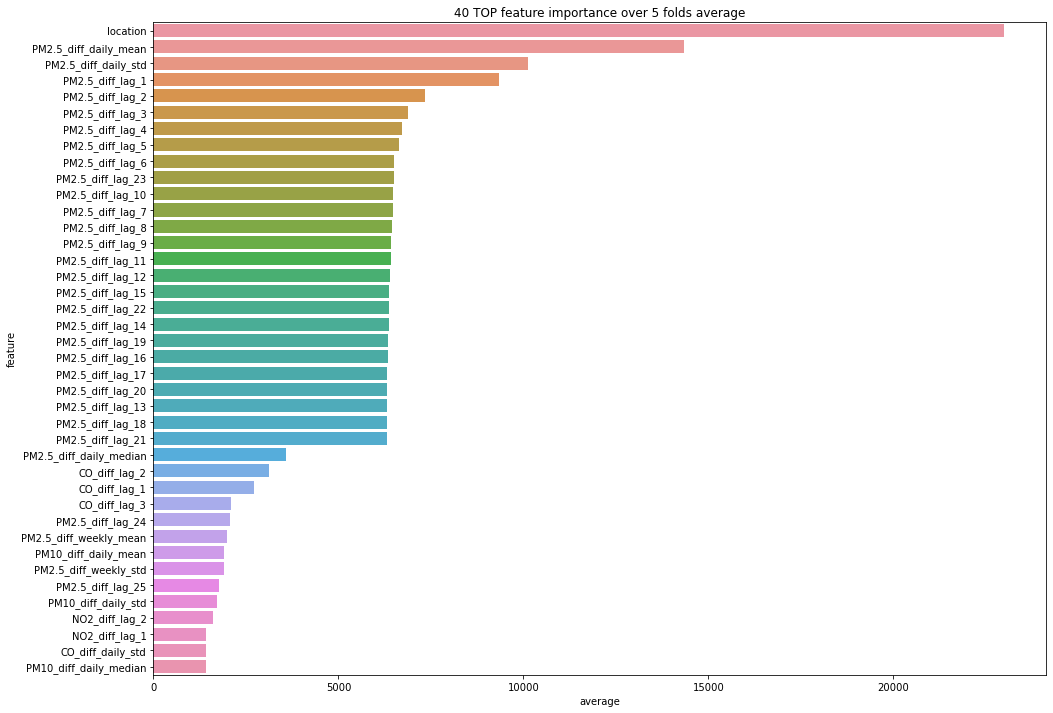

In [43]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(40), x='average', y='feature')
plt.title('40 TOP feature importance over {} folds average'.format(n_splits))

In [47]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 841128 entries, 2014-04-03 01:00:00 to 2016-12-29 09:00:00
Columns: 115 entries, PM2.5_diff_lag_1 to target
dtypes: float64(114), object(1)
memory usage: 744.4+ MB


In [370]:
allTarget_noNA.to_csv('insample_cluster_lr1_ff.csv',index=True)

In [371]:
allTestTarget_noNA.to_csv('outsample_cluster_lr_ff.csv',index=True)

In [375]:
outsample_lr1_ff = pd.read_csv('outsample_lr1_ff.csv',index_col=0)

In [376]:
insample_lr1_ff = pd.read_csv('insample_lr1_ff.csv',index_col=0)

In [377]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(insample_lr1_ff["prediction"],insample_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(outsample_lr1_ff["prediction"],outsample_lr1_ff["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(insample_lr1_ff["PM2.5_y"],insample_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(outsample_lr1_ff["PM2.5_y"],outsample_lr1_ff["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.153714551492689
Out of sample RMSE for LightGBM method is 13.678590435962686
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [378]:
outsample_lr1_noImp = pd.read_csv('outsample_lr1_noImp.csv',index_col=0)
insample_lr1_noImp = pd.read_csv('insample_lr1_noImp.csv',index_col=0)

In [379]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(insample_lr1_noImp["prediction"],insample_lr1_noImp["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(outsample_lr1_noImp["prediction"],outsample_lr1_noImp["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(insample_lr1_noImp["PM2.5_y"],insample_lr1_noImp["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(outsample_lr1_noImp["PM2.5_y"],outsample_lr1_noImp["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.178666477272593
Out of sample RMSE for LightGBM method is 14.786081088738703
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [383]:
outsample_cluster_lr1_ff = pd.read_csv('outsample_cluster_lr_ff.csv',index_col=0)
insample_cluster_lr1_ff = pd.read_csv('insample_cluster_lr1_ff.csv',index_col=0)

In [384]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(insample_cluster_lr1_ff["prediction"],insample_cluster_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(outsample_cluster_lr1_ff["prediction"],outsample_cluster_lr1_ff["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(insample_cluster_lr1_ff["PM2.5_y"],insample_cluster_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(outsample_cluster_lr1_ff["PM2.5_y"],outsample_cluster_lr1_ff["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.138040849216537
Out of sample RMSE for LightGBM method is 12.781554818110596
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [385]:
outsample_knn_lr1_ff = pd.read_csv('outsample_knn_lr1_ff.csv',index_col=0)
insample_knn_lr1_ff = pd.read_csv('insample_knn_lr1_ff.csv',index_col=0)

In [387]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(insample_knn_lr1_ff["prediction"],insample_knn_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(outsample_knn_lr1_ff["prediction"],outsample_knn_lr1_ff["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(insample_knn_lr1_ff["PM2.5_y"],insample_knn_lr1_ff["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(outsample_knn_lr1_ff["PM2.5_y"],outsample_knn_lr1_ff["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.04740615122957
Out of sample RMSE for LightGBM method is 12.445125130090132
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [401]:
emsemble = outsample_cluster_lr1_ff['prediction']*0.5+outsample_knn_lr1_ff['prediction']*0.5

In [402]:
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(emsemble,outsample_knn_lr1_ff["PM2.5"]))}')

Out of sample RMSE for LightGBM method is 12.349368265248016


In [394]:
emsemble

Datetime
2017-01-01 23:00:00    502.116289
2017-01-02 00:00:00    471.762059
2017-01-02 01:00:00    481.676477
2017-01-02 02:00:00    510.132437
2017-01-02 03:00:00    467.414319
                          ...    
2017-04-29 19:00:00     58.270269
2017-04-29 20:00:00     48.176012
2017-04-29 21:00:00     54.320900
2017-04-29 22:00:00     45.285593
2017-04-29 23:00:00     47.134225
Name: prediction, Length: 82748, dtype: float64